In [177]:
import numpy as np
import matplotlib.pyplot as plt
import os
cwd = os.getcwd()
os.chdir('/Users/thomak/Research/GCMutils')
import GCMutils as gcm
import PFutils as PF
os.chdir(cwd)

In [266]:
Tirr = 1700
Tint = 365
g = 21.2 * 100  # cm/s2
kV = 4e-3 #cm^2/g
kth = 1e-2 #cm^2/g


In [267]:
def insert_IC(dir, Tinit):
    path = f'{dir}/fort.7'
    with open(path, 'r') as f:
        lines = f.readlines()

    start_line = end_line = None
    for i, line in enumerate(lines):
        if 'RESTTT' in line:
            start_line = i
        elif 'REDTEP' in line:
            end_line = i
            break

    if start_line is None or end_line is None:
        raise ValueError("Could not find 'RESTTT' and/or 'REDTEP' markers in the file.")

    insert_line = ' RESTTT = ' + ', '.join(f'{float(T):.6f}' for T in Tinit)+ '\n'
    new_lines = lines[: start_line] + [insert_line] + lines[end_line:]
    with open(path, 'w') as f:
        f.writelines(new_lines)

# insert_IC('test', Tguillot)

In [ ]:
import shutil
import os

if not os.path.exists('testsavg'):
    os.makedirs('testsavg')
if not os.path.exists('testsavghires'):
    os.makedirs('testsavghires')
if not os.path.exists('testsprofs'):
    os.makedirs('testsprofs')
if not os.path.exists('testsprofshires'):
    os.makedirs('testsprofshires')
if not os.path.exists('tests_murt3_ISFvar'):
    os.makedirs('tests_murt3_ISFvar')
if not os.path.exists('tests_murt3_ISFvar_hires'):
    os.makedirs('tests_murt3_ISFvar_hires')
if not os.path.exists('tests'):
    os.makedirs('tests')
if not os.path.exists('testshires'):
    os.makedirs('testshires')

# P = np.loadtxt('1Kday/Planet_Run_gray_davg/fort.8', skiprows=1).T[0]
rtmethods = ['gray', 'picket']
locs = ['davg', 'pavg', 'savg']
fs = [0.5, 0.25, 1.0]
for rtmethod in rtmethods:
    for iloc, loc in enumerate(locs):
        fnm = f'{rtmethod}_{loc}'
        shutil.copy('test/fort.7', f'testsavg/fort.7')
        # Tint = 365
        if rtmethod == 'gray':
            Tinit = gcm.avg_guillot_tp(P/1e5, Tirr, Tint, g, kth, kV, f=fs[iloc])
        elif rtmethod == 'picket':
            Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), 1/np.sqrt(3),fs[iloc],g/100, P, 50, ALBEDO="USER", Ab=0.05)[0]
        insert_IC('testsavg', Tinit)
        # Tint=100
        shutil.move('testsavg/fort.7', f'testsavg/{fnm}')
        with open(f'testsavg/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            elif rtmethod == 'picket':
                data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')
            if loc == 'davg':
                data = data.replace(' ISF = 0.25', ' ISF = 0.5')
            elif loc == 'pavg':
                data = data.replace(' ISF = 0.25', ' ISF = 0.25')
            elif loc == 'savg':
                data = data.replace(' ISF = 0.25', ' ISF = 1.0')
        with open(f'testsavg/{fnm}', 'w') as f:
            f.write(data)

for rtmethod in rtmethods:
    for iloc, loc in enumerate(locs):
        fnm = f'{rtmethod}_{loc}_hires'
        shutil.copy('testhires/fort.7', f'testsavghires/fort.7')
        Phires = np.logspace(np.log10(1.17), np.log10(8.51e6), 100)
        # Tint = 365
        if rtmethod == 'gray':
            Tinit = gcm.avg_guillot_tp(Phires/1e5, Tirr, Tint, g, kth, kV, f=fs[iloc])
        elif rtmethod == 'picket':
            Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), 1/np.sqrt(3), fs[iloc], g/100, Phires, 100, ALBEDO="USER", Ab=0.0, CONV='NO')[0]
        # Tint = 100
        insert_IC('testsavghires', Tinit)
        shutil.move('testsavghires/fort.7', f'testsavghires/{fnm}')
        with open(f'testsavghires/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            elif rtmethod == 'picket':
                data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')
            if loc == 'davg':
                data = data.replace(' ISF = 0.25', ' ISF = 0.5')
            elif loc == 'pavg':
                data = data.replace(' ISF = 0.25', ' ISF = 0.25')
            elif loc == 'savg':
                data = data.replace(' ISF = 0.25', ' ISF = 1.0')
        with open(f'testsavghires/{fnm}', 'w') as f:
            f.write(data)


thetas = np.array([0,30,40,50,60,80,85,89,90])
labels1 = thetas.astype(str)
mus = np.cos(np.radians(thetas))
# P = np.loadtxt('1Kday/Planet_Run_gray_davg/fort.8', skiprows=1).T[0]
rtmethods = ['gray']
# locs = ['davg', 'pavg', 'savg']
# fs = [0.5, 0.25, 1.0]
for rtmethod in rtmethods:
    for imu, mulabel in enumerate(labels1):
        fnm = f'{rtmethod}_{mulabel}'
        shutil.copy('test/fort.7', f'testsprofs/fort.7')
        if rtmethod == 'gray':
            Tinit = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth, kV, mu=mus[imu], f=mus[imu])
        # elif rtmethod == 'picket':
        #     Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), mus[imu], mus[imu],g/100, P, 50, ALBEDO="USER", Ab=0.0, CONV='NO')[0]
        insert_IC('testsprofs', Tinit)
        shutil.move('testsprofs/fort.7', f'testsprofs/{fnm}')
        ISF = mus[imu]
        MU = mus[imu]
        with open(f'testsprofs/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            # elif rtmethod == 'picket':
            #     data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')
            data = data.replace(' ISF = 0.25', f' ISF = {ISF}')
            for line in data.splitlines():
                if 'MUSTEL' in line:
                    old_mu = line.split('=')[1].strip()
                    break
            data = data.replace(old_mu, f'{MU}')

        with open(f'testsprofs/{fnm}', 'w') as f:
            f.write(data)
for rtmethod in rtmethods:
    for imu, mulabel in enumerate(labels1):
        fnm = f'{rtmethod}_{mulabel}_hires'
        shutil.copy('test/fort.7', f'testsprofshires/fort.7')
        if rtmethod == 'gray':
            Tinit = gcm.guillot_tp(Phires/1e5, Tirr, Tint, g, kth, kV, mu=mus[imu], f=mus[imu])
        elif rtmethod == 'picket':
            Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), mus[imu], mus[imu],g/100, Phires, 100, ALBEDO="USER", Ab=0.0, CONV='NO')[0]
        insert_IC('testsprofshires', Tinit)
        shutil.move('testsprofshires/fort.7', f'testsprofshires/{fnm}')
        ISF = mus[imu]
        MU = mus[imu]
        with open(f'testsprofshires/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            # elif rtmethod == 'picket':
            #     data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')
            data = data.replace(' ISF = 0.25', f' ISF = {ISF}')
            for line in data.splitlines():
                if 'MUSTEL' in line:
                    old_mu = line.split('=')[1].strip()
                    break
            data = data.replace(old_mu, f'{MU}')

        with open(f'testsprofshires/{fnm}', 'w') as f:
            f.write(data)

fs = np.arange(0.0,1.01,0.1)
# P = np.loadtxt('1Kday/Planet_Run_gray_davg/fort.8', skiprows=1).T[0]
rtmethods = ['gray']
# locs = ['davg', 'pavg', 'savg']
# fs = [0.5, 0.25, 1.0]
for rtmethod in rtmethods:
    for iff, f in enumerate(fs):
        fnm = f'{rtmethod}_{f:.1f}'
        shutil.copy('test/fort.7', f'tests_murt3_ISFvar/fort.7')
        if rtmethod == 'gray':
            Tinit = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth, kV, mu=1/np.sqrt(3), f=f)
        elif rtmethod == 'picket':
            Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), mus[imu], mus[imu],g/100, P, 50, ALBEDO="USER", Ab=0.0, CONV='NO')[0]
        insert_IC('tests_murt3_ISFvar', Tinit)
        shutil.move('tests_murt3_ISFvar/fort.7', f'tests_murt3_ISFvar/{fnm}')
        ISF = f
        MU = 1/np.sqrt(3)
        with open(f'tests_murt3_ISFvar/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            elif rtmethod == 'picket':
                data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')
            data = data.replace(' ISF = 0.25', f' ISF = {ISF}')
            for line in data.splitlines():
                if 'MUSTEL' in line:
                    old_mu = line.split('=')[1].strip()
                    break
            data = data.replace(old_mu, f'{MU}')
        with open(f'tests_murt3_ISFvar/{fnm}', 'w') as f:
            f.write(data)
for rtmethod in rtmethods:
    for iff, f in enumerate(fs):
        fnm = f'{rtmethod}_{f:.1f}_hires'
        shutil.copy('testhires/fort.7', f'tests_murt3_ISFvar_hires/fort.7')
        if rtmethod == 'gray':
            Tinit = gcm.guillot_tp(Phires/1e5, Tirr, Tint, g, kth, kV, mu=1/np.sqrt(3), f=f)
        elif rtmethod == 'picket':
            Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), mus[imu], mus[imu],g/100, Phires, 100, ALBEDO="USER", Ab=0.0, CONV='NO')[0]
        insert_IC('tests_murt3_ISFvar_hires', Tinit)
        shutil.move('tests_murt3_ISFvar_hires/fort.7', f'tests_murt3_ISFvar_hires/{fnm}')
        ISF = f
        MU = 1/np.sqrt(3)
        with open(f'tests_murt3_ISFvar_hires/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            elif rtmethod == 'picket':
                data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')
            data = data.replace(' ISF = 0.25', f' ISF = {ISF}')
            for line in data.splitlines():
                if 'MUSTEL' in line:
                    old_mu = line.split('=')[1].strip()
                    break
            data = data.replace(old_mu, f'{MU}')
        with open(f'tests_murt3_ISFvar_hires/{fnm}', 'w') as f:
            f.write(data)

thetas = np.array([0,30,60,85])
labels = thetas.astype(str)
mus = np.cos(np.radians(thetas))
isfs = mus
# P = np.loadtxt('1Kday/Planet_Run_gray_davg/fort.8', skiprows=1).T[0]
rtmethods = ['gray', 'picket']
for iisf, isf in enumerate(isfs):
    for imu, mulabel in enumerate(labels):
        fnm = f'ISF{labels[iisf]}_MU{mulabel}'
        shutil.copy('test/fort.7', f'tests/fort.7')
        if rtmethod == 'gray':
            Tinit = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth, kV, mu=mus[imu], f=isfs[iisf])
        elif rtmethod == 'picket':
            Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), mus[imu], mus[imu],g/100, P, 50, ALBEDO="USER", Ab=0.0, CONV='NO')[0]
        insert_IC('tests', Tinit)
        shutil.move('tests/fort.7', f'tests/{fnm}')
        ISF = isfs[iisf]
        MU = mus[imu]
        with open(f'tests/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            elif rtmethod == 'picket':
                data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')

            data = data.replace(' ISF = 0.25', f' ISF = {ISF}')
            data = data.replace(' MUSTEL = 0.5', f' MUSTEL = {MU}')

        with open(f'tests/{fnm}', 'w') as f:
            f.write(data)
for iisf, isf in enumerate(isfs):
    for imu, mulabel in enumerate(labels):
        fnm = f'ISF{labels[iisf]}_MU{mulabel}_hires'
        shutil.copy('testhires/fort.7', f'testshires/fort.7')
        if rtmethod == 'gray':
            # Tint=100
            Tinit = gcm.guillot_tp(Phires/1e5, Tirr, Tint, g, kth, kV, mu=mus[imu], f=isfs[iisf])
        elif rtmethod == 'picket':
            Tinit = PF.PFtprofile(Tint, Tirr/np.sqrt(2), mus[imu], mus[imu],g/100, Phires, 100, ALBEDO="USER", Ab=0.0, CONV='NO')[0]
        insert_IC('testshires', Tinit)
        shutil.move('testshires/fort.7', f'testshires/{fnm}')
        ISF = isfs[iisf]
        MU = mus[imu]
        with open(f'testshires/{fnm}', 'r') as f:
            data = f.read()
            if rtmethod == 'gray':
                data = data.replace('picket_fence_optical_depths = T', 'picket_fence_optical_depths = F')
            elif rtmethod == 'picket':
                data = data.replace('picket_fence_optical_depths = F', 'picket_fence_optical_depths = T')

            data = data.replace(' ISF = 0.25', f' ISF = {ISF}')
            data = data.replace(' MUSTEL = 0.5', f' MUSTEL = {MU}')

        with open(f'testshires/{fnm}', 'w') as f:
            f.write(data)

Teff0: 1431.0404190693266
Teff0: 1204.6279475896208
Teff0: 1700.9024411728815
Teff0: 1431.0404190693266
Teff0: 1204.6279475896208
Teff0: 1700.9024411728815


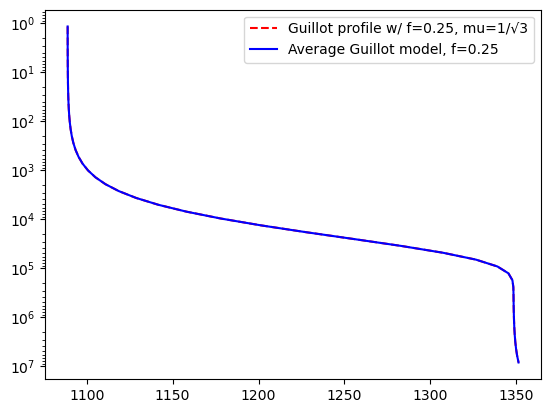

In [269]:
plt.plot(gcm.guillot_tp(P/1e5, Tirr, 100, g, kth, kV, mu=1/np.sqrt(3), f=0.25), P, label='Guillot profile w/ f=0.25, mu=1/√3', c='r', ls='--')
plt.plot(gcm.avg_guillot_tp(P/1e5, Tirr, 100, g, kth, kV, f=0.25), P, label='Average Guillot model, f=0.25', c='b')
plt.legend()
plt.yscale('log')
plt.gca().invert_yaxis()

Text(0.5, 1.0, '1-D RT profiles vs Guillot analytic model')

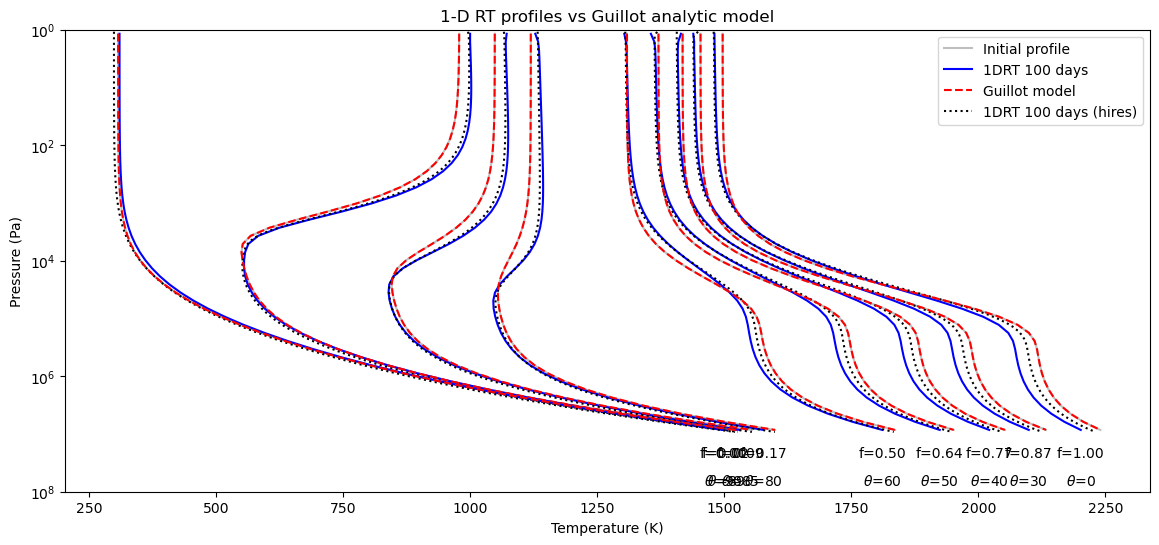

In [ ]:
### now actually run them, then:
plt.figure(figsize=(14,6))
for test in os.listdir('testsprofs'):
    if test =='params.i':
        continue
    dir = "Planet_Run_" + test
    if not os.path.exists(dir):
        continue
    
    P, T, dummy = np.loadtxt(f'{dir}/1000.day_fort.8', skiprows=1).T
    PHR, THR, dummy = np.loadtxt(f'{dir}_hires/1000.day_fort.8', skiprows=1).T
    Tinit = gcm.getIC(dir)
    f = np.cos(np.radians(float(test.split('_')[1])))
    Tguillotmod = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth, kV, mu=f, f=f)
    plt.plot(Tinit, P, 'gray', alpha=0.5)
    plt.plot(T, P, 'b-')
    plt.plot(THR, PHR, 'k--')
    plt.plot(Tguillotmod, P, 'r--')
    plt.text(T[-1], P[-1]*3, f'f={f:.2f}', ha='center')
    plt.text(T[-1], P[-1]*9, rf'$\theta$={np.degrees(np.arccos(f)):.0f}', ha='center')

    # plt.title(test)
    plt.yscale('log')
    plt.gca().invert_yaxis()

    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (Pa)')
    plt.ylim(10e7,1e0)
plt.plot([],[], 'gray', label='Initial profile', alpha=0.5)
plt.plot([],[], 'b-', label='1DRT 100 days')
plt.plot([],[], 'r--', label='Guillot model')
plt.plot([],[], 'k--', label='1DRT 100 days (hires)')
plt.legend()
plt.title('1-D RT profiles vs Guillot analytic model')
    # plt.legend()
    # plt.show()

Text(0.5, 1.0, '1-D RT profiles vs Guillot analytic models with mu=1/√3')

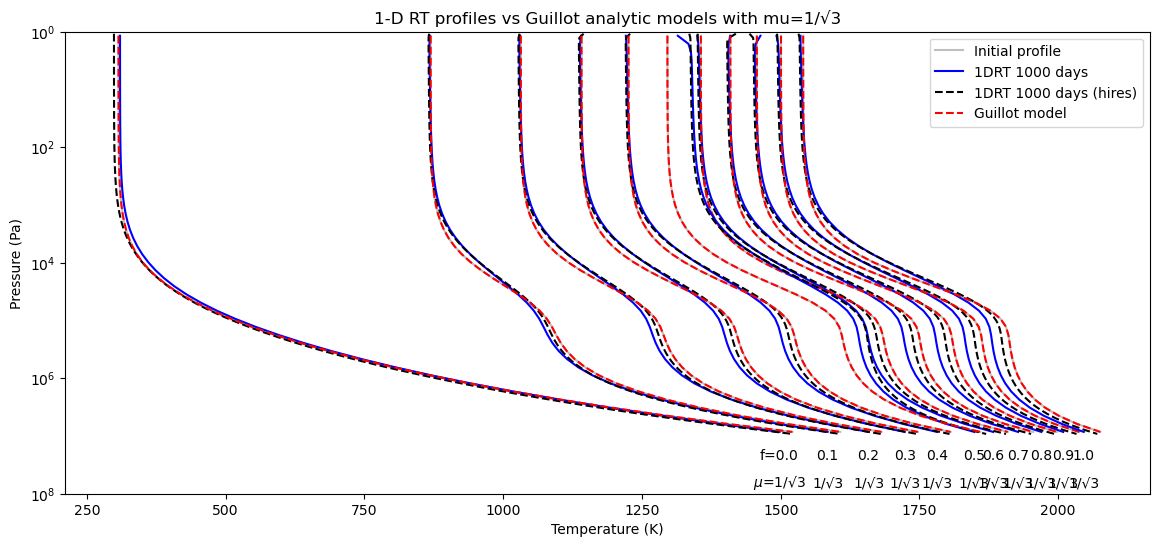

In [304]:
### now actually run them, then:
plt.figure(figsize=(14,6))
for test in os.listdir('tests_murt3_ISFvar'):
    if test =='params.i':
        continue
    dir = "Planet_Run_" + test
    if not os.path.exists(dir):
        continue
    # print(dir)
    P, T, dummy = np.loadtxt(f'{dir}/1000.day_fort.8', skiprows=1).T
    PHR, THR, dummy = np.loadtxt(f'{dir}_hires/1000.day_fort.8', skiprows=1).T
    Tinit = gcm.getIC(dir)
    f =float(test.split('_')[1])
    # print(f)
    Tguillotmod = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth, kV, mu=1/np.sqrt(3), f=f)
    plt.plot(Tinit, P, 'gray', alpha=0.5)
    plt.plot(T, P, 'b-')
    plt.plot(THR, PHR, 'k--')
    plt.plot(Tguillotmod, P, 'r--')

    if f>0:
        plt.text(T[-1], P[-1]*3, f'{f:.1f}', ha='center')
        plt.text(T[-1], P[-1]*9, rf'1/√3', ha='center')
    else:
        plt.text(T[-1], P[-1]*3, 'f=0.0', ha='center')
        plt.text(T[-1], P[-1]*9, r'$\mu$=1/√3', ha='center')

    # plt.title(test)
    plt.yscale('log')
    plt.gca().invert_yaxis()

    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (Pa)')
    plt.ylim(10e7,1e0)
plt.plot([],[], 'gray', label='Initial profile', alpha=0.5)
plt.plot([],[], 'b-', label='1DRT 1000 days')
plt.plot([],[], 'k--',label='1DRT 1000 days (hires)')
plt.plot([],[], 'r--', label='Guillot model')
plt.legend()
plt.title('1-D RT profiles vs Guillot analytic models with mu=1/√3')
    # plt.legend()
    # plt.show()

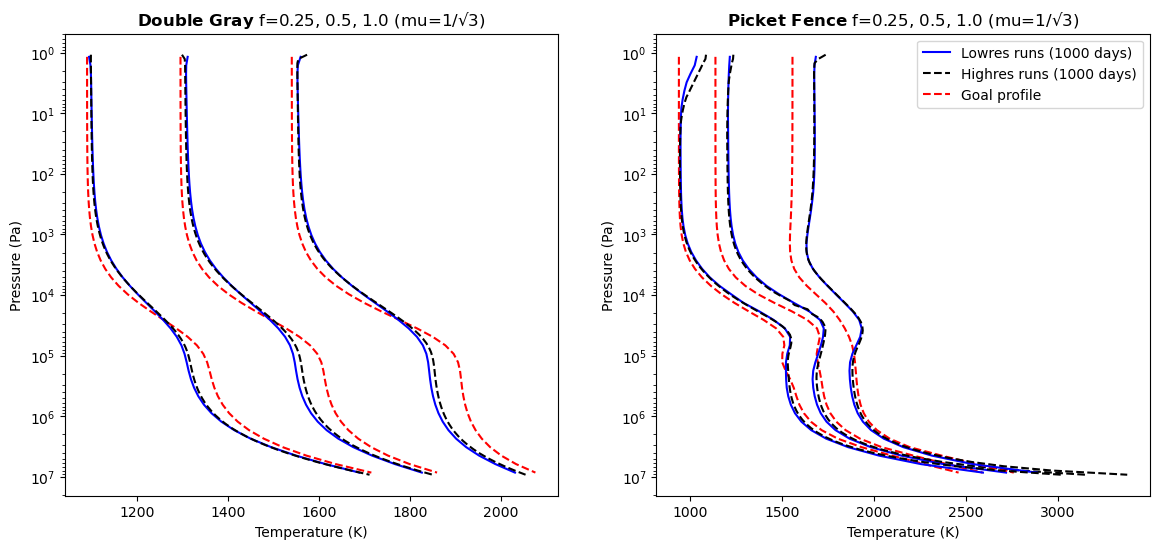

In [305]:
### now actually run them, then:
P, T, blah = np.loadtxt(f'Planet_Run_gray_davg/1000.day_fort.8', skiprows=1).T

fig, ax = plt.subplots(figsize=(14,6), ncols=2)
for test in os.listdir('testsavg'):
    dir = "Planet_Run_" + test
    if not os.path.exists(dir):
        continue
    if 'gray' in test:
        i=0
    else:
        i=1
    
    # P, T, dummy = np.loadtxt(f'{dir}/1000.day_fort.8', skiprows=1).T
    # Tinit = gcm.getIC(dir)

    # ax[i].plot(Tinit, P, label='Initial profile', c='gray', alpha=0.5)
    # ax[i].plot(T, P, label='1DRT 1K days', c='k')

    Tinit = gcm.getIC(f'Planet_Run_{test}')
    ax[i].plot(Tinit, P, 'r--')
    P, T, blah = np.loadtxt(f'Planet_Run_{test}/1000.day_fort.8', skiprows=1).T
    PHR, THR, blah = np.loadtxt(f'Planet_Run_{test}_hires/1000.day_fort.8', skiprows=1).T
    ax[i].plot(T, P, 'b-')
    ax[i].plot(THR, PHR, 'k--')
ax[1].plot([],[], 'b-', label='Lowres runs (1000 days)')
ax[1].plot([],[], 'k--', label='Highres runs (1000 days)')
ax[1].plot([],[], 'r--', label='Goal profile')

ax[0].set_title(r'$\bf{Double\,\, Gray}$ f=0.25, 0.5, 1.0 (mu=1/√3)')
ax[1].set_title(r'$\bf{Picket\,\, Fence}$ f=0.25, 0.5, 1.0 (mu=1/√3)')
# ax[1].set_title('picket')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel('Pressure (Pa)')

plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.legend()
    # plt.show()

In [273]:
# from matplotlib import cycler

# ### recreate fully 1-D collimated starlight profiles in Guillot fig 2:
# cmap = plt.get_cmap('tab10')
# n = len(labels1)
# base_colors = [cmap(i/(n-1)) for i in range(n)]

# plt.figure(figsize=(8,8))
# # plt.gca().set_prop_cycle(cycler('color', paired))
# plt.plot([],[], c='k', label='Guillot', ls='-')
# plt.plot([],[], c='k', label='GCM', ls='--')
# for ci, theta in enumerate(labels1):
#     P, T, dummy = np.loadtxt(f'Planet_Run_gray_{theta}/100.day_fort.8', skiprows=1).T
#     theta = float(theta)
#     mu = np.cos(np.radians(theta))
#     kth2 = 1e-2
#     kv2 = 4e-3
#     Teq2 = 1700/np.sqrt(2)
#     Tint2 = 100
#     Tguillot, tau = gcm.guillot_tp(P/1e5, Teq2*np.sqrt(2), Tint2, g, kth2, kv2, mu, return_tau=True)
#     plt.plot(Tguillot, P/1e5, label=fr'$\Theta={theta:.0f}^\circ$', c=base_colors[ci], ls='-')
#     plt.plot(T, P/1e5, ls='--', c=base_colors[ci])
#     if float(theta) != 90:
#         plt.axhline(g * mu/kv2/1e6, ls='-', c=base_colors[ci])

# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('Pressure (bar)')
# plt.title('Double Gray: different zenith angles (mu=f)')
# # Tguillotavg, tau = gcm.avg_guillot_tp(P/1e5, Teq2*np.sqrt(2), Tint2, g, kth2, kv2, f=0.25, return_tau=True)
# # plt.plot(Tguillotavg, tau, label='isotropic approx.', linestyle='--')
# # Tguillotavg, tau = gcm.guillot_tp(P/1e5, Teq2, Tint2, g, kth2, kv2, 1, return_tau=True)
# # plt.plot(Tguillotavg, tau, label='substel, isotropic', linestyle='--')

# # plt.xscale('log')
# plt.yscale('log')
# plt.gca().invert_yaxis()

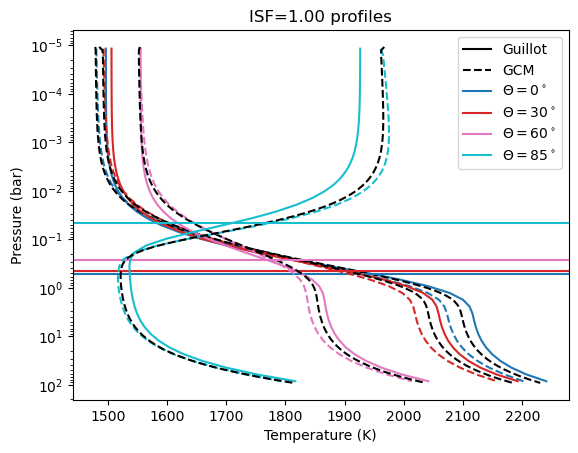

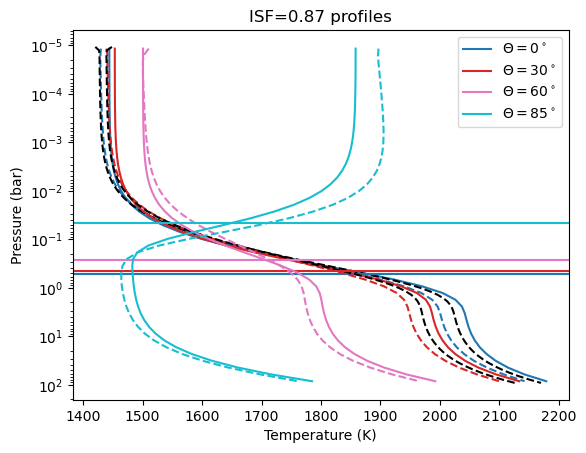

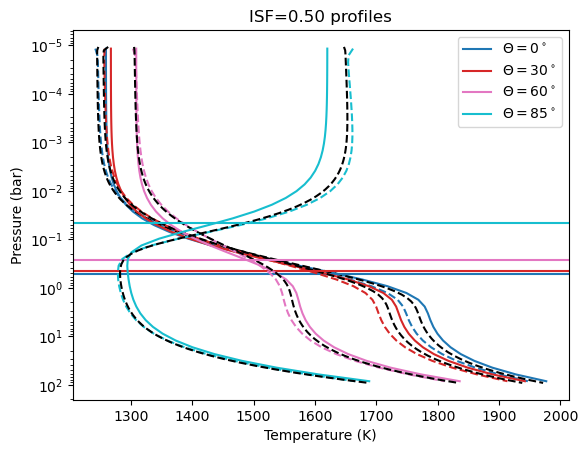

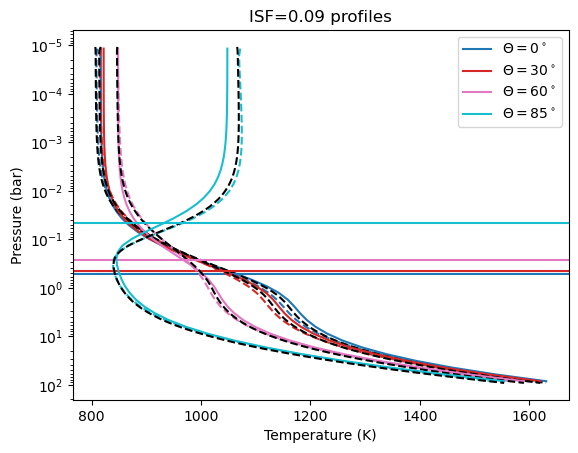

In [314]:
from matplotlib import cycler

### recreate fully 1-D collimated starlight profiles in Guillot fig 2:
cmap = plt.get_cmap('tab10')
labels2 = np.array([0,30,60,85]).astype(str)
n = len(labels2)
base_colors = [cmap(i/(n-1)) for i in range(n)]

scaleIR = 1 #np.sqrt(2)
scalevis = 1

# plt.figure(figsize=(8,8))
# plt.gca().set_prop_cycle(cycler('color', paired))
plt.plot([],[], c='k', label='Guillot', ls='-')
plt.plot([],[], c='k', label='GCM', ls='--')
for ISF in labels2:
    for ci, theta in enumerate(labels2):
        P, T, TTRD = np.loadtxt(f'./Planet_Run_ISF{ISF}_MU{theta}/1000.day_fort.8', skiprows=1).T
        PHR, THR, TTRDHR = np.loadtxt(f'./Planet_Run_ISF{ISF}_MU{theta}_hires/1000.day_fort.8', skiprows=1).T
        theta = float(theta)
        mu = np.cos(np.radians(theta))
        kth2 = 1e-2 * scaleIR
        kv2 = 4e-3 * scalevis
        # Teq2 = 1700/np.sqrt(2)
        # Tint2 = 100
        Tguillot, tau = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth2, kv2, mu, f=np.cos(np.radians(float(ISF))), return_tau=True)
        # Tinit = gcm.getIC(f'./Planet_Run_ISF0_MU{int(theta)}')
        plt.plot(Tguillot, P/1e5, label=fr'$\Theta={theta:.0f}^\circ$', c=base_colors[ci], ls='-')
        plt.plot(T, P/1e5, ls='--', c=base_colors[ci])
        plt.plot(THR, PHR/1e5, ls='--', c='k')
        # plt.plot(Tinit, P/1e5, ls=':', c=base_colors[ci])

        if float(theta) != 90:
            plt.axhline(g * mu/kv2/1e6, ls='-', c=base_colors[ci])

    plt.title(f'ISF={np.cos(np.radians(float(ISF))):.2f} profiles')
    plt.legend()
    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (bar)')
    # Tguillotavg, tau = gcm.avg_guillot_tp(P/1e5, Teq2*np.sqrt(2), Tint2, g, kth2, kv2, f=0.25, return_tau=True)
    # plt.plot(Tguillotavg, tau, label='isotropic approx.', linestyle='--')
    # Tguillotavg, tau = gcm.guillot_tp(P/1e5, Teq2, Tint2, g, kth2, kv2, 1, return_tau=True)
    # plt.plot(Tguillotavg, tau, label='substel, isotropic', linestyle='--')

    # plt.xscale('log')
    plt.yscale('log')
    plt.gca().invert_yaxis()
    plt.show()

# from matplotlib import cycler

# ### recreate fully 1-D collimated starlight profiles in Guillot fig 2:
# cmap = plt.get_cmap('tab10')
# n = len(labels)
# base_colors = [cmap(i/(n-1)) for i in range(n)]

# plt.figure(figsize=(8,8))
# # plt.gca().set_prop_cycle(cycler('color', paired))
# plt.plot([],[], c='k', label='Guillot', ls='-')
# plt.plot([],[], c='k', label='GCM', ls='--')
# for ci, theta in enumerate(labels):
#     P, T, TTRD = np.loadtxt(f'./Planet_Run_ISF{theta}_MU0/100.day_fort.8', skiprows=1).T
#     theta = int(theta)
#     mu = np.cos(np.radians(theta))
#     kth2 = 1e-2 * scaleIR
#     kv2 = 4e-3 * scalevis
#     # Teq = 1700/np.sqrt(2)
#     # Tint = 100
#     Tguillot, tau = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth2, kv2, mu=1, f=mu, return_tau=True)
#     # Tinit = gcm.getIC(f'./Planet_Run_ISF{theta}_MU0')

#     plt.plot(Tguillot, P/1e5, label=fr'$ISF={np.cos(np.radians(theta)):.2f}$', c=base_colors[ci], ls='-')
#     plt.plot(T, P/1e5, ls='--', c=base_colors[ci])
#     # plt.plot(Tinit, P/1e5, ls=':', c=base_colors[ci])
#     if float(theta) != 90:
#         plt.axhline(g * mu/kv2/1e6, ls='-', c=base_colors[ci])

# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('Pressure (bar)')
# # Tguillotavg, tau = gcm.avg_guillot_tp(P/1e5, Teq2*np.sqrt(2), Tint2, g, kth2, kv2, f=0.25, return_tau=True)
# # plt.plot(Tguillotavg, tau, label='isotropic approx.', linestyle='--')
# # Tguillotavg, tau = gcm.guillot_tp(P/1e5, Teq2, Tint2, g, kth2, kv2, 1, return_tau=True)
# # plt.plot(Tguillotavg, tau, label='substel, isotropic', linestyle='--')

# # plt.xscale('log')
# plt.yscale('log')
# plt.gca().invert_yaxis()

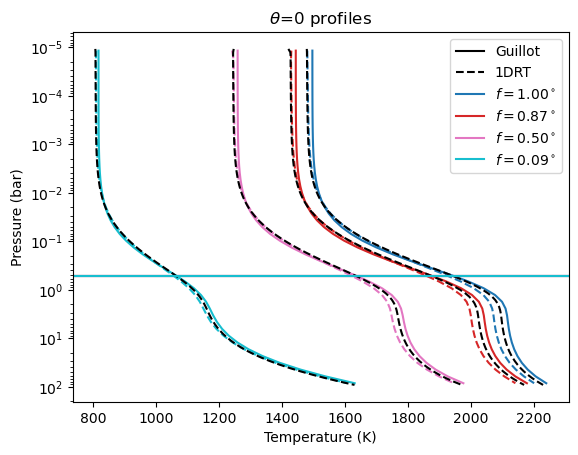

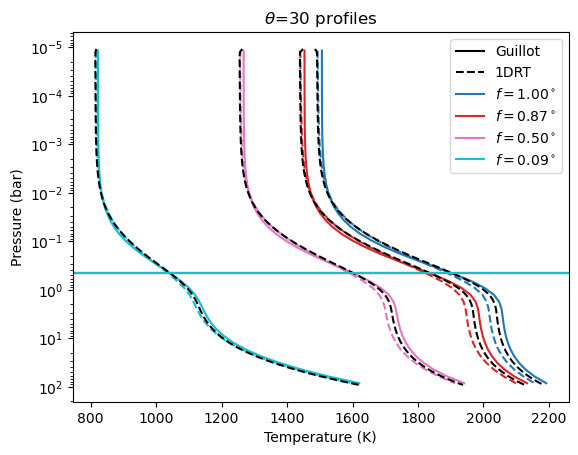

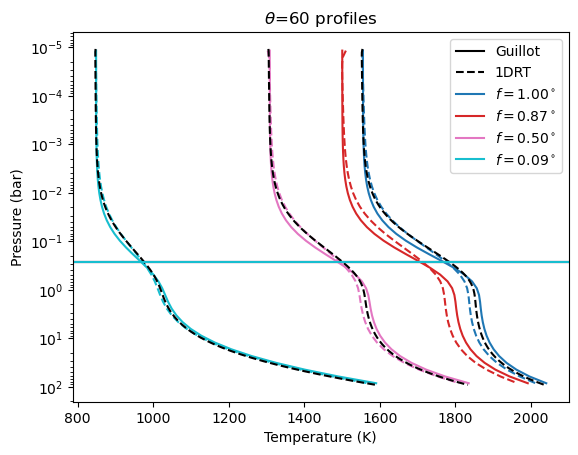

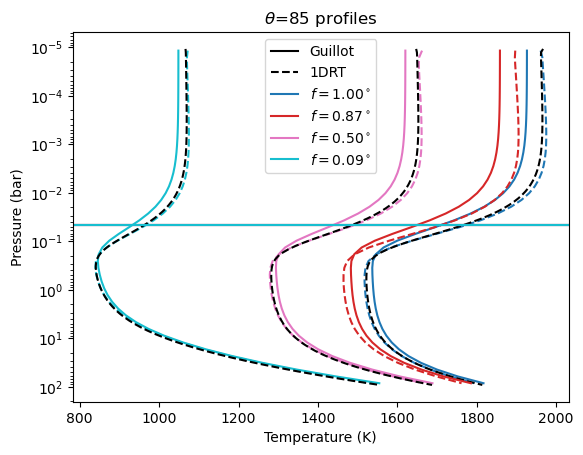

In [313]:
from matplotlib import cycler

### recreate fully 1-D collimated starlight profiles in Guillot fig 2:
cmap = plt.get_cmap('tab10')
labels2 = np.array([0,30,60,85]).astype(str)
n = len(labels2)
base_colors = [cmap(i/(n-1)) for i in range(n)]

scaleIR = 1 #np.sqrt(2)
scalevis = 1

# plt.figure(figsize=(8,8))
# plt.gca().set_prop_cycle(cycler('color', paired))


for theta in labels2:
    plt.plot([],[], c='k', label='Guillot', ls='-')
    plt.plot([],[], c='k', label='1DRT', ls='--')
    for ci, ISF in enumerate(labels2):
        P, T, TTRD = np.loadtxt(f'./Planet_Run_ISF{ISF}_MU{theta}/1000.day_fort.8', skiprows=1).T
        PHR, THR, TTRDHR = np.loadtxt(f'./Planet_Run_ISF{ISF}_MU{theta}_hires/1000.day_fort.8', skiprows=1).T
        mu = np.cos(np.radians(float(theta)))
        f = np.cos(np.radians(float(ISF)))
        kth2 = 1e-2
        kv2 = 4e-3
        Tguillot, tau = gcm.guillot_tp(P/1e5, Tirr, Tint, g, kth2, kv2, mu, f=f, return_tau=True)
        # Tinit = gcm.getIC(f'./Planet_Run_ISF0_MU{int(theta)}')
        plt.plot(Tguillot, P/1e5, label=fr'$f={f:.2f}^\circ$', c=base_colors[ci], ls='-')
        plt.plot(T, P/1e5, ls='--', c=base_colors[ci])
        plt.plot(THR, PHR/1e5, ls='--', c='k')
        # plt.plot(Tinit, P/1e5, ls=':', c=base_colors[ci])

        if float(theta) != 90:
            plt.axhline(g * mu/kv2/1e6, ls='-', c=base_colors[ci])

    plt.title(rf'$\theta$={theta} profiles')
    plt.legend()
    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (bar)')

    # plt.xscale('log')
    plt.yscale('log')
    plt.gca().invert_yaxis()
    plt.show()


In [276]:
listt = os.listdir('./Planet_Run_ISF30_MU0')
listt.sort()
listt

['100.day_fort.8',
 '1000.day_fort.8',
 '1DRT',
 '200.day_fort.8',
 '300.day_fort.8',
 '400.day_fort.8',
 '500.day_fort.8',
 '600.day_fort.8',
 '700.day_fort.8',
 '800.day_fort.8',
 '900.day_fort.8',
 'fort.2',
 'fort.60',
 'fort.7']

compare to quality of 100 D 3D gcm runs:

In [277]:
dfgavg = gcm.read_file('../RM-GCM/Planet_Run_gavg/RM-GCMPlanet_Run_gavg.txt')
dfdavg = gcm.read_file('../RM-GCM/Planet_Run_davg/RM-GCMPlanet_Run_davg.txt')

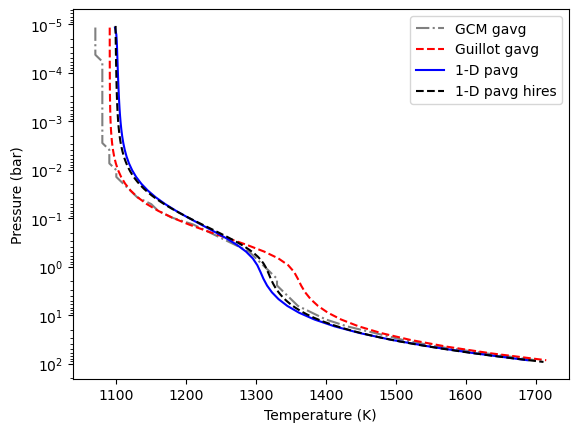

In [309]:
dfgavg = dfgavg[(dfgavg['lon'] == 135) & (dfgavg['lat'] == 59.44)]
plt.plot(dfgavg['temp'], dfgavg['pres'], label='GCM gavg', c='gray', ls='-.')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (bar)')

Tguillotavg, tau = gcm.avg_guillot_tp(P/1e5, Tirr, Tint, g, kth2, kv2, f=0.25, return_tau=True)
plt.plot(Tguillotavg, P/1e5, label='Guillot gavg', c='red', ls='--' )
# for d in range(0,1001,100):
# d=1000
P,T,dummy = np.loadtxt(f'Planet_Run_gray_pavg/1000.day_fort.8', skiprows=1).T
PHR, THR, dummy = np.loadtxt(f'Planet_Run_gray_pavg_hires/1000.day_fort.8', skiprows=1).T
plt.plot(T, P/1e5, label='1-D pavg', c='b', ls='-')
plt.plot(THR, PHR/1e5, label='1-D pavg hires', c='k', ls='--')
plt.legend()

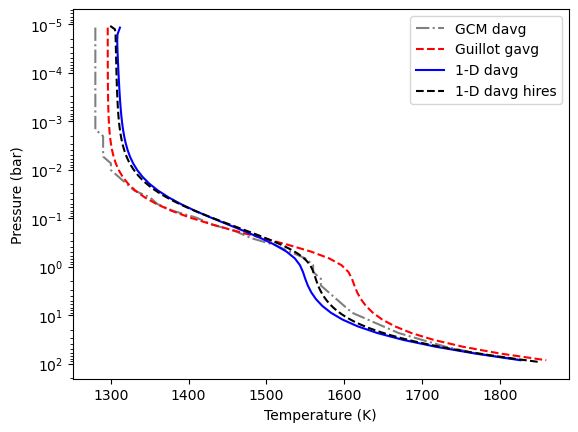

In [310]:
dfdavg = dfdavg[(dfgavg['lon'] == 135) & (dfdavg['lat'] == 59.44)]

plt.plot(dfdavg['temp'], dfdavg['pres'], label='GCM davg', c='gray', ls='-.')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (bar)')
Tguillotavg, tau = gcm.avg_guillot_tp(P/1e5, Tirr, Tint, g, kth2, kv2, f=0.5, return_tau=True)
plt.plot(Tguillotavg, P/1e5, label='Guillot gavg', c='red', ls='--' )
insert_IC('../RM-GCM/Planet_Run_davg', Tguillotavg)
P,T, dummy = np.loadtxt('Planet_Run_gray_davg/1000.day_fort.8', skiprows=1).T
PHR, THR, dummy = np.loadtxt('Planet_Run_gray_davg_hires/1000.day_fort.8', skiprows=1).T
plt.plot(T, P/1e5, label='1-D davg', c='b', ls='-')
plt.plot(THR, PHR/1e5, label='1-D davg hires', c='k', ls='--')
plt.legend()